## 1.导入包

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import re
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
"""
网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合
网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况
下面要做的事情：
1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动
2.考虑正则化或者假如droput层来防止过拟合
3.考虑数据预处理中采用数据标准化，让数据均匀分布
4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）
5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例
6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量
"""

'\n网格搜索(Grid Search)和Optuna，找到模型的最佳超参数组合\n网格搜索适用于超参数空间较小、离散且较少的情况，而Optuna适用于超参数空间较大、连续或离散且较多的情况\n下面要做的事情：\n1.换新的面心值标签，现在数据过拟合，训练集下降但是测试集上升或者波动\n2.考虑正则化或者假如droput层来防止过拟合\n3.考虑数据预处理中采用数据标准化，让数据均匀分布\n4.用不用考虑损失函数，学习率,epoch,adam优化器及其四个参数，的修改，模型用不用再添加几层让模型变复杂些（batch-size越大，训练越快，不影响准确率）\n5.早停法（Early Stopping）：在训练过程中监控验证集上的性能，一旦性能停止改善，在一定epoch后停止训练，并保存模型，以防止过拟合。可以参照外国那案例\n6.数据集的比例，不一定4：1，也可以95：5，当数据集足够大时，这样可以增加训练集数量\n'

## 2.加载数据

"""
1.功能：
通过加载data和label文件，然后继续训练和预测。
定义了一个6层卷积神经网络模型。每个卷积层后面跟着一个 ReLU 激活函数。第七层只有卷积，没有relu。
输入数据n*64*64*2,这里的一个样本64*64可以看成一个图片格式（在此次任务中是速度，两者类似）
输出是n*64*64*4
"""
"""txt保存为numpy格式发现可以减少存储大小，约缩小成1/4
5.9G	./all_data.npy
12G	./all_label.npy
27G	./data_64x64x2.txt
53G	./label_a_2x64x65x2.txt
"""

In [3]:
# 直接加载npy文件为numpy格式
all_data = np.load('./data/all_data.npy')
# #直接加载npy文件为numpy格式
all_label = np.load('./data/all_centerFace_label.npy')

all_data = torch.tensor(all_data).float()
all_label = torch.tensor(all_label).float()


## 3.构建模型

In [4]:

#神经网络模型
class Net(nn.Module):
    def __init__(self, num_output_channels):
        super(Net, self).__init__()

        # 第一层卷积，使用64个大小为3x3的卷积核，输入数据的shape为2x64x64，使用ReLU激活函数。
        # 输入通道数为2，输出通道数恒为64
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()

        # 第二层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        # 第三层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # 第四层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()

        # 第五层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()

        # 第六层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu6 = nn.ReLU()

        # 第七层卷积，使用64个大小为3x3的卷积核，使用ReLU激活函数,输出数据为4*64*64
        # 输入通道数为64，输出通道数恒为4
        self.conv7 = nn.Conv2d(64, num_output_channels, kernel_size=3, stride=1, padding=1)



    def forward(self, x):
        x = self.conv1(x)  # x:torch.Size([10, 2, 64, 64])
        x = self.relu1(x)

        x = self.conv2(x)  # x:torch.Size([10, 64, 64, 64])
        x = self.relu2(x)

        x = self.conv3(x)  # x:  torch.Size([10, 64, 64, 64])
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.relu5(x)

        x = self.conv6(x)
        x = self.relu6(x)

        x = self.conv7(x)

        # 输出数据shape: torch.Size([10, 4, 64, 64]),10是batch_size大小
        return x



## 4.模型训练与测试

In [5]:
def train(num_output_channels):
    
    import time
    start_time = time.time()

    # 定义一个batch包含的样本数目
    batch_size =128

    # 生成数据集
    x_train, x_test, y_train, y_test = train_test_split(all_data, all_label, test_size=0.2)

    # 设置种子数
    seed = 42
    torch.manual_seed(seed)

    # 划分数据集
    trainset = torch.utils.data.TensorDataset(x_train, y_train)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True)

    # 划分数据集
    testset = torch.utils.data.TensorDataset(x_test, y_test)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=True)


    # 创建模型实例，并将模型移动到GPU设备上进行计算
    net = Net(num_output_channels).to(device)
    
    # 加速训练：如果有多个GPU，则使用DataParallel模块
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
        print("采用DataParallel加速，device_count个数为：",str(torch.cuda.device_count()))
        
    # 定义损失函数为均方误差
    criterion = nn.MSELoss()  # 将预测值与真实标签之间的差值求平方和，再除以样本数n来得到平均损失值

    # 定义优化器为Adam优化器,设置学习率为0.001
    optimizer = optim.Adam(net.parameters(),lr = 0.001)

    print('begin to train!!!')

    # 训练模型
    num_epochs = 1  # 训练轮数
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # 将参数的梯度设为0
            optimizer.zero_grad()

            # 前向传播+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])
            loss.backward()  # 有了损失值后，就可以根据反向传播算法来更新模型参数，使得预测值更接近真实标签。
            optimizer.step()

            # 统计损失值
            running_train_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
                        # 每20个batch打印一次平均损失值，这里batch-size=10,相当于每100个样本打印一次loss
#             if i % 20 == 19:
#                 print('[epoch:  %d, batch:%5d] train loss: %.3f' %
#                       (epoch + 1, i + 1, running_train_loss))
        print("running_train_loss:",running_train_loss)        
        train_loss.append(running_train_loss)
            

                
        running_test_loss = 0.0
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            # 前向传播(预测)+后向传播+优化
            outputs = net(inputs)
            # inputs:torch.Size([10, 2, 64, 64])
            # outputs:torch.Size([10, 4, 64, 64])
            """
            criterion：表示所选的损失函数，这里选择的是MSE均方误差
            outputs：模型在输入后得到的输出，它的形状是(batch_size, num_output_channels, height, width)
            """
            loss = criterion(outputs, labels)  # labels   :torch.Size([10, 120, 64, 64])

            # 统计损失值
            running_test_loss += loss.item()  # 在训练过程中，目标就是通过反向传播和优化算法尽可能地减小该损失值，提高模型的性能。
            
        print("running_test_loss:",running_test_loss)        
        test_loss.append(running_test_loss)
        print("已完成第：",str(epoch+1),"个epoch!")


    end_time = time.time()
    process_time = end_time - start_time
    print(f"模型训练和测试共用了: {process_time} 秒！")#预处理data用了: 705.8258590698242 秒！
    print('all of tasks Finished')
    
    # 保存整个模型
    torch.save(net, './model/model_origin_100.pth')
    
    return train_loss,test_loss


"""
已完成第： 60 个epoch!
模型训练和测试共用了: 2325.386168241501 秒！
"""
train_loss,test_loss  = train(num_output_channels=4)
print(train_loss)
print(test_loss)
# 将数据写入文件，格式只能为二进制,二进制数据无法查看，想查看的话可以将其写入到txt里面或者用deebug查看
np.save('./data/lossa/loss_model_100.npy', np.array([train_loss,test_loss]))

采用DataParallel加速，device_count个数为： 4
begin to train!!!
running_train_loss: 2549.1050159931183
running_test_loss: 606.6772332191467
已完成第： 1 个epoch!
模型训练和测试共用了: 51.282381772994995 秒！
all of tasks Finished
[2549.1050159931183]
[606.6772332191467]


In [6]:
print(all_data.shape)
print(all_label.shape)


torch.Size([192000, 2, 64, 64])
torch.Size([192000, 4, 64, 64])


In [7]:
train_loss,test_loss = np.load('./data/lossa/loss_model_100.npy')
print(train_loss)

[2549.10501599]


# 5.可视化loss

[0.0166]


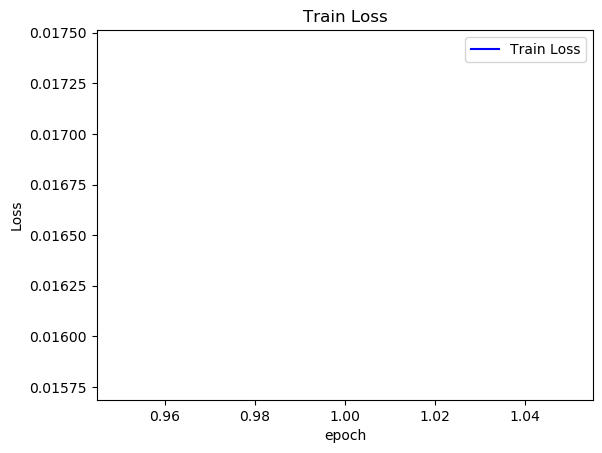

In [8]:
import matplotlib.pyplot as plt
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(train_loss) + 1)

train_loss = [round(int(a)/(all_data.shape[0]*0.8), 5) for a in train_loss]
print(train_loss)
# 绘制训练损失曲线
plt.plot(epoch, train_loss, 'b', label='Train Loss')

# 关闭科学计数法
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# 设置y轴范围下限为0
# plt.ylim(bottom=0)

# 设置图表标题和轴标签
plt.title('Train Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

[606.67723322]


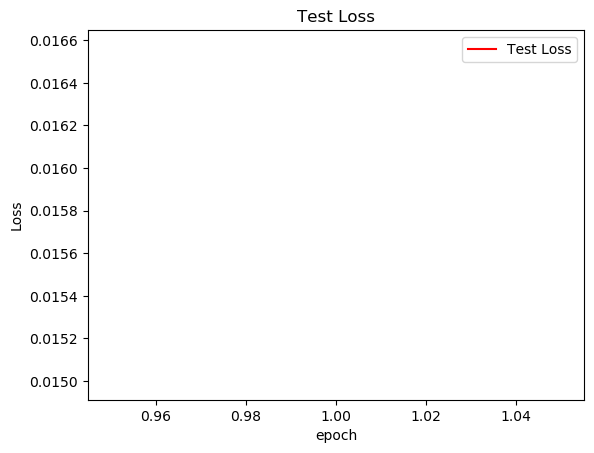

In [9]:
# 创建 x 轴数据，假设为 epoch 数
epoch = np.arange(1, len(test_loss) + 1)
print(test_loss)
test_loss = [round(int(a)/(all_data.shape[0]*0.2), 5) for a in test_loss]


# 绘制测试损失曲线
plt.plot(epoch, test_loss, 'r', label='Test Loss')

# 设置图表标题和轴标签
plt.title('Test Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [11]:
# 加载模型
model = torch.load('./model/model_origin_100.pth')

AttributeError: 'DataParallel' object has no attribute 'summary'